# Machine Learning Capstone Project - Starbucks


Importing necessary libraries and datasets

In [345]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime as dt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

In this first section we are going to explore the 3 datasets at hand.
We will also use plots to get a sense of what data is avaiable and how we might want to use it.
The goal of this phase is to get an insight on the datasets at hands and identify potential issues to tackle.

### Portfolio Dataset 

In [120]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [121]:
portfolio.shape

(10, 6)

The portfolio has information about the offers Starbucks put forward. We see that 2 columns need to be one-hot encoded: Channels and offer_type.


In [122]:
#How many channels available do we have?
lst=[]
for var in portfolio['channels']:
    lst+=var
set(lst)

{'email', 'mobile', 'social', 'web'}

In [123]:
#How many offer_type?
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Profile Dataset

The profile dataset has information about our customers. 

In [124]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [125]:
profile.shape

(17000, 5)

In [126]:
#Missing values? It appears we have a number of missing values, and Age is set to be 118 for those.
#Let's confirm the count of rows with age 118
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [127]:
profile[profile['age']==118]
#As we thought, where age is 118 we have missing gender and income. Let's dropped these before visualizing some distributions.

gender  age                                id  became_member_on  income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6       None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7       None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
...      ...  ...                               ...               ...     ...
16980   None  118  5c686d09ca4d475a8f750f2ba07e0440          20160901     NaN
16982   None  118  d9ca82f550ac4ee58b6299cf1e5c824a          20160415     NaN
16989   None  118  ca45ee1883624304bac1e4c8a114f045          20180305     NaN
16991   None  118  a9a20fa8b5504360beb4e7c8712f8306          20160116     NaN
16994   None  118  c02b10e8752c4d8e9b73f918558531f7          20151211     NaN

[2175 rows x 5 columns]

In [128]:
profile=profile[profile['age']!=118]
#We will need to one hot encode gender and perhaps transform the variable "became_member_on" to
#Something that tells us the customer tenure, such as number of days since customer joined.

In [129]:
profile.gender.value_counts()/profile.gender.value_counts().sum()*100
#57% Males
#41% Females
#1.4 Others

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

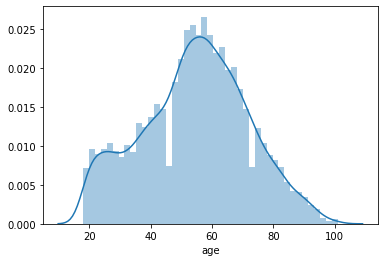

In [130]:
sns.distplot(profile['age'])
#Median Age is 55, distribution isn't exactly normal

In [131]:
profile['age'].median()

55.0

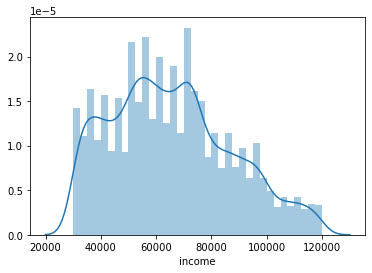

In [132]:
sns.distplot(profile['income'])

In [133]:
profile['income'].median()

64000.0

### Transcript Dataset

The transcript dataset is essentially a mapping between the event and the offer. 

In [134]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [135]:
#How many types of event?
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [136]:
#Count of each?
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

It appears dataset is fairly balanced for our purposes (offers completed/Offers received is approx 56%)
We need to extract the offer ID and remove the transaction event type as we are only interested in teh offers.

## Data Pre-processing and Feature Engineering

In this section we will combine the datasets and tackle the issues we identified in our EDA, including data cleaning.

The goal at the end of this section is to have a unique datasets for our Supervised Learning models.
The following data cleaning steps will be executed:

1. One Hot encode the offer_type column from the portfolio dataset
2. One Hot encode the channels column from the portfolio dataset 
3. One Hot encode the gender column from the profile dataset 
4. Transform the became_member_on column into tenure days
5. Remove missing values from profile dataset
6. Remove events not offer related from transactions dataset
7. Extract offer ID from value column in transactions dataset
8. Reshape the transaction dataset to have the event type as one hot encoded column
9. Extract total amount spent from transactions for each customer
10. Create a column to mark whether an offer was successful or not
11. Join the 3 datasets and create a unique dataframe

In [137]:
#Encoding Offer_type
portfolio=pd.get_dummies(portfolio,columns=['offer_type'],drop_first=True)
portfolio.head(3)

reward                      channels  difficulty  duration  \
0      10       [email, mobile, social]          10         7   
1      10  [web, email, mobile, social]          10         5   
2       0          [web, email, mobile]           0         4   

                                 id  offer_type_discount  \
0  ae264e3637204a6fb9bb56bc8210ddfd                    0   
1  4d5c57ea9a6940dd891ad53e9dbe8da0                    0   
2  3f207df678b143eea3cee63160fa8bed                    0   

   offer_type_informational  
0                         0  
1                         0  
2                         1

In [138]:
#Encoding channels
channels=['email', 'mobile', 'social', 'web']
for channel in channels:
    portfolio[channel]=0
    
for channel in channels:
    portfolio[channel]=portfolio.apply(lambda row: 1 if channel in row['channels'] else 0,axis=1)


In [139]:
portfolio=portfolio.drop(columns=['channels'])
portfolio.head()

reward  difficulty  duration                                id  \
0      10          10         7  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0   
2       0           0         4  3f207df678b143eea3cee63160fa8bed   
3       5           5         7  9b98b8c7a33c4b65b9aebfe6a799e6d9   
4       5          20        10  0b1e1539f2cc45b7b9fa7c272da2e1d7   

   offer_type_discount  offer_type_informational  email  mobile  social  web  
0                    0                         0      1       1       1    0  
1                    0                         0      1       1       1    1  
2                    0                         1      1       1       0    1  
3                    0                         0      1       1       0    1  
4                    1                         0      1       0       0    1

In [140]:
#Encoding Gender
profile=pd.get_dummies(profile,columns=['gender'],drop_first=True)

In [141]:
profile.head(3)

age                                id  became_member_on    income  \
1   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0   
3   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0   
5   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0   

   gender_M  gender_O  
1         0         0  
3         0         0  
5         1         0

In [142]:
#adding tenure from became_member_on
profile['became_member_on']=pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['tenure']=profile['became_member_on'].apply(lambda x: (datetime.now() - x).days)

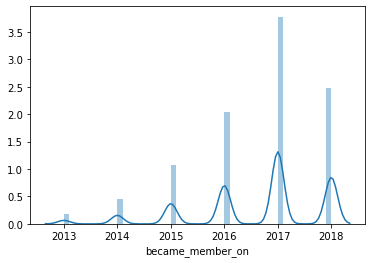

In [150]:
sns.distplot(profile.became_member_on.dt.year)
#It seems most users joined in 2017, but most of them joined after 2016

In [152]:
profile=profile.drop(columns=['became_member_on'])

In [157]:
profile.columns=['age', 'customerid', 'income', 'gender_M', 'gender_O', 'tenure']
profile.head(2)

age                        customerid    income  gender_M  gender_O  tenure
1   55  0610b486422d4921ae7d2bf64640c50b  112000.0         0         0    1267
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         0         0    1334

In [216]:
#Extracting amount spent for each customer
transactions=transcript[transcript['event']=='transaction'].copy()
transactions['amount']=transactions['value'].apply(lambda x:x['amount'])
total_spent_customer=transactions.groupby(['person']).sum()['amount'].reset_index()

In [217]:
set([k[0] for k in [list(k.keys()) for k in transcript[transcript['event']=='transaction'].value]])

{'amount'}

In [218]:
#Removing the transactions
transcript=transcript[transcript['event']!='transaction'].copy()

In [219]:
#Checking what keys to get
set([k[0] for k in [list(k.keys()) for k in transcript[transcript['event']!='transaction'].value]])

{'offer id', 'offer_id'}

In [220]:
transcript['offer_id']=transcript['value'].apply(lambda x:x['offer id'] if 'offer id' in x else x['offer_id'])

In [224]:
transcript=pd.get_dummies(transcript,columns=['event'])

In [229]:
#Removing columns we won't need
transcript=transcript.drop(columns=['value','time','event_offer received','event_offer viewed'])

In [233]:
#Removing duplicates if any
transcript=transcript.drop_duplicates()

In [251]:
#If offer was sent twice and accepted at least once, we consider it.
transcript=transcript.groupby(['person','offer_id']).sum().reset_index()
transcript['event_offer completed']=transcript['event_offer completed'].apply(lambda x:0 if x==0 else 1)

In [252]:
transcript

person                          offer_id  \
0      0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5   
1      0009655768c64bdeb2e877511632db8f  3f207df678b143eea3cee63160fa8bed   
2      0009655768c64bdeb2e877511632db8f  5a8bc65990b245e5a138643cd4eb9837   
3      0009655768c64bdeb2e877511632db8f  f19421c1d4aa40978ebb69ca19b0e20d   
4      0009655768c64bdeb2e877511632db8f  fafdcd668e3743c1bb461111dcafc2a4   
...                                 ...                               ...   
63283  fffad4f4828548d1b5583907f2e9906b  f19421c1d4aa40978ebb69ca19b0e20d   
63284  ffff82501cea40309d5fdd7edcca4a07  0b1e1539f2cc45b7b9fa7c272da2e1d7   
63285  ffff82501cea40309d5fdd7edcca4a07  2906b810c7d4411798c6938adc9daaa5   
63286  ffff82501cea40309d5fdd7edcca4a07  9b98b8c7a33c4b65b9aebfe6a799e6d9   
63287  ffff82501cea40309d5fdd7edcca4a07  fafdcd668e3743c1bb461111dcafc2a4   

       event_offer completed  
0                          1  
1                          0  
2                          0  
3                          1  
4                          1  
...                      ...  
63283                      1  
63284                      1  
63285                      1  
63286                      1  
63287                      1  

[63288 rows x 3 columns]

In [ ]:
#Our Datasets are now ready to be merged together

In [234]:
portfolio.head(3)

reward  difficulty  duration                                id  \
0      10          10         7  ae264e3637204a6fb9bb56bc8210ddfd   
1      10          10         5  4d5c57ea9a6940dd891ad53e9dbe8da0   
2       0           0         4  3f207df678b143eea3cee63160fa8bed   

   offer_type_discount  offer_type_informational  email  mobile  social  web  
0                    0                         0      1       1       1    0  
1                    0                         0      1       1       1    1  
2                    0                         1      1       1       0    1

In [235]:
profile.head(3)

age                        customerid    income  gender_M  gender_O  tenure
1   55  0610b486422d4921ae7d2bf64640c50b  112000.0         0         0    1267
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         0         0    1334
5   68  e2127556f4f64592b11af22de27a7932   70000.0         1         0     982

In [236]:
transcript.head(3)

person                          offer_id  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  a03223e636434f42ac4c3df47e8bac43  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5   

   event_offer completed  
0                      0  
1                      0  
2                      0

In [237]:
total_spent_customer.head(3)

person  amount
0  0009655768c64bdeb2e877511632db8f  127.60
1  00116118485d4dfda04fdbaba9a87b5c    4.09
2  0011e0d4e6b944f998e987f904e8c1e5   79.46

In [253]:
combined=pd.merge(profile,total_spent_customer,how='left',left_on=['customerid'],right_on=['person'])
combined=combined.drop(columns=['person'])
combined=pd.merge(combined,transcript,how='left',left_on=['customerid'],right_on=['person'])
combined=combined.drop(columns=['person'])
combined=pd.merge(combined,portfolio,how='left',left_on=['offer_id'],right_on=['id'])
combined=combined.drop(columns=['id'])

In [258]:
combined.head()

age                        customerid    income  gender_M  gender_O  \
0   55  0610b486422d4921ae7d2bf64640c50b  112000.0         0         0   
1   55  0610b486422d4921ae7d2bf64640c50b  112000.0         0         0   
2   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         0         0   
3   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         0         0   
4   75  78afa995795e4d85b5d9ceeca43f5fef  100000.0         0         0   

   tenure  amount                          offer_id  event_offer completed  \
0    1267   77.01  3f207df678b143eea3cee63160fa8bed                    0.0   
1    1267   77.01  9b98b8c7a33c4b65b9aebfe6a799e6d9                    1.0   
2    1334  159.27  5a8bc65990b245e5a138643cd4eb9837                    0.0   
3    1334  159.27  9b98b8c7a33c4b65b9aebfe6a799e6d9                    1.0   
4    1334  159.27  ae264e3637204a6fb9bb56bc8210ddfd                    1.0   

   reward  difficulty  duration  offer_type_discount  \
0     0.0         0.0       4.0                  0.0   
1     5.0         5.0       7.0                  0.0   
2     0.0         0.0       3.0                  0.0   
3     5.0         5.0       7.0                  0.0   
4    10.0        10.0       7.0                  0.0   

   offer_type_informational  email  mobile  social  web  
0                       1.0    1.0     1.0     0.0  1.0  
1                       0.0    1.0     1.0     0.0  1.0  
2                       1.0    1.0     1.0     1.0  0.0  
3                       0.0    1.0     1.0     0.0  1.0  
4                       0.0    1.0     1.0     1.0  0.0

In [259]:
combined.describe()

age         income      gender_M      gender_O        tenure  \
count  55227.000000   55227.000000  55227.000000  55227.000000  55227.000000   
mean      54.351169   65388.089159      0.573017      0.013924   1412.277129   
std       17.392878   21626.435118      0.494644      0.117178    419.329095   
min       18.000000   30000.000000      0.000000      0.000000    891.000000   
25%       42.000000   49000.000000      0.000000      0.000000   1098.000000   
50%       55.000000   63000.000000      1.000000      0.000000   1248.000000   
75%       66.000000   80000.000000      1.000000      0.000000   1687.000000   
max      101.000000  120000.000000      1.000000      1.000000   2714.000000   

             amount  event_offer completed        reward    difficulty  \
count  53992.000000           55222.000000  55222.000000  55222.000000   
mean     121.900275               0.505994      4.204737      7.718554   
std      131.900320               0.499969      3.402301      5.547981   
min        0.150000               0.000000      0.000000      0.000000   
25%       35.010000               0.000000      2.000000      5.000000   
50%       91.675000               1.000000      5.000000     10.000000   
75%      166.520000               1.000000      5.000000     10.000000   
max     1608.690000               1.000000     10.000000     20.000000   

           duration  offer_type_discount  offer_type_informational    email  \
count  55222.000000         55222.000000              55222.000000  55222.0   
mean       6.508239             0.400547                  0.199938      1.0   
std        2.205656             0.490014                  0.399957      0.0   
min        3.000000             0.000000                  0.000000      1.0   
25%        5.000000             0.000000                  0.000000      1.0   
50%        7.000000             0.000000                  0.000000      1.0   
75%        7.000000             1.000000                  0.000000      1.0   
max       10.000000             1.000000                  1.000000      1.0   

             mobile        social           web  
count  55222.000000  55222.000000  55222.000000  
mean       0.898808      0.599181      0.799337  
std        0.301585      0.490069      0.400500  
min        0.000000      0.000000      0.000000  
25%        1.000000      0.000000      1.000000  
50%        1.000000      1.000000      1.000000  
75%        1.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

In [260]:
#Email appears to have all 1s, let's remove it
combined=combined.drop(columns=['email'])
combined=combined.fillna(method='backfill')

In [261]:
#Final Dimensions
combined.shape

(55227, 17)

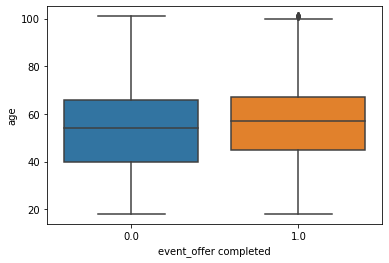

In [265]:
#Let's check the distribution of some variables vs our target
sns.boxplot(combined['event_offer completed'],combined['age'])

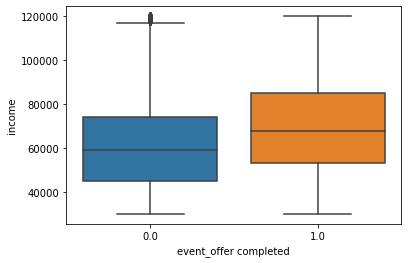

In [266]:
sns.boxplot(combined['event_offer completed'],combined['income'])

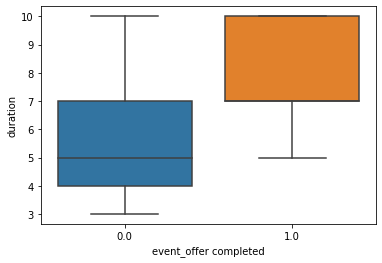

In [268]:
sns.boxplot(combined['event_offer completed'],combined['duration'])

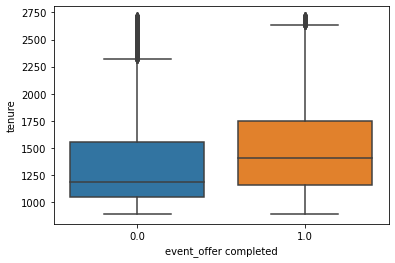

In [269]:
sns.boxplot(combined['event_offer completed'],combined['tenure'])

In [305]:
combined['event_offer completed'].value_counts()/combined['event_offer completed'].value_counts().sum()

1.0    0.505966
0.0    0.494034
Name: event_offer completed, dtype: float64

### EDA and pre-processing conclusions

We now have a unique dataset to work with and a list of features to use to predict whether an offer will be completed or not.
We have identified some features that divide whether an offer was completed or not such as tenure,duration and some others such 
as age that doesn't really separate the offer completed from the offers not completed.
Before moving into the modelling part we will try visualizing the data and see if in the hyperdimensional space there is a natural separation across our features.
After the data processing our dataset is strongly balanced.
We did not scale the data for the purpose of Random Forest and XGBoost which will be our main algorithms. 
Only distant based algorithms such as KNN, SVM and Neural Networks require feature scaling. Both Random Forest and XGBoost are based on trees and different scales will not be an issue.

## Unsupervised Learning - PCA

In this section we will try visualizing the data and see if there are 2 natural clusters that divide the offers completed from the offers not completed. We will leverage the principal components of the datasets to visualize the data and color the points based on whether the order was completed or not. To run PCA we will scale the features.

In [297]:
combined
target_col=['event_offer completed']
categoricalcols=['customerid','offer_id']
X,Y=combined[[col for col in combined.columns if col not in ['customerid','offer_id','event_offer completed']]],combined['event_offer completed']

In [300]:
scaler=StandardScaler()

scaled_data=scaler.fit_transform(X)

pca = decomposition.PCA()
pca.fit(scaled_data)
pccols=['PC'+str(i) for i in range(1,len(X.columns)+1)]
X_PCA = pd.DataFrame(pca.transform(X),columns=[pccols])
X_PCA.columns=pccols
X_PCA.head()

PC1          PC2           PC3          PC4           PC5  \
0 -101.108853  3193.334807  66222.437742 -6579.053890 -24096.132259   
1  -96.138109  3197.629059  66222.191576 -6578.848142 -24096.097654   
2  -90.247771  2858.881615  59209.743335 -6024.031832 -21389.050519   
3  -84.397159  2862.378924  59209.528210 -6023.837345 -21389.037721   
4  -81.647649  2867.102268  59209.261831 -6023.601974 -21388.962011   

           PC6         PC7          PC8           PC9          PC10  \
0 -1907.590071  195.445583  8841.946037  25768.030847 -82340.972486   
1 -1909.127422  194.416261  8842.071790  25768.114224 -82340.964403   
2 -1709.661015  161.813059  7838.292266  22975.165912 -73495.897338   
3 -1710.918317  159.943757  7838.501663  22975.293168 -73495.872236   
4 -1713.222912  159.514305  7838.606603  22975.371139 -73495.867087   

         PC11        PC12       PC13      PC14  
0 -187.003453 -408.626202 -39.535307  8.482646  
1 -186.164952 -408.610917 -42.947476  7.505419  
2 -167.781574 -364.013355 -35.021180  7.536607  
3 -166.534640 -364.664248 -38.844579  6.686750  
4 -167.032398 -362.632452 -42.106262  5.473948

In [301]:
for i in pca.explained_variance_ratio_:
    print(i,sep=' ')

0.26303901680174335
0.13162939266625112
0.11909525548891511
0.07909162073720882
0.07350957084547867
0.07272706831418335
0.06383285485860701
0.05995657030918486
0.05445831424283631
0.04224367669894017
0.024408223278051776
0.009943824641715634
0.005031626037189414
0.001032985079694476


In [302]:

trace1 = go.Scatter3d(x = X_PCA["PC1"][Y==1],
                      y = X_PCA["PC2"][Y==1],
                      z = X_PCA["PC3"][Y==1],
                      mode = "markers",
                      name = "Offer Completed",
                      marker = dict(size = 1,color = "red")
                     )
trace2 = go.Scatter3d(x = X_PCA["PC1"][Y==0],
                      y = X_PCA["PC2"][Y==0],
                      z = X_PCA["PC3"][Y==0],
                      name = "Offer not completed",
                      mode = "markers",
                      marker = dict(size = 1,color= "green")
                     )



layout = go.Layout(dict(title = "Customer completing order on principal component axis",
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = "PC1",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = "PC2",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = "PC3",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )
                                    ),
                        height = 700,
                       )
                  )
                  

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
py.iplot(fig)

Due to the high presence of categorical features, the points are sort of clustered towards the central axis. 
But we do see a clear separation between the green and the red points, but also an area where they strongly overlap.
We will need a strong classifier in a hyperdimensional space to achieve high accuracy.

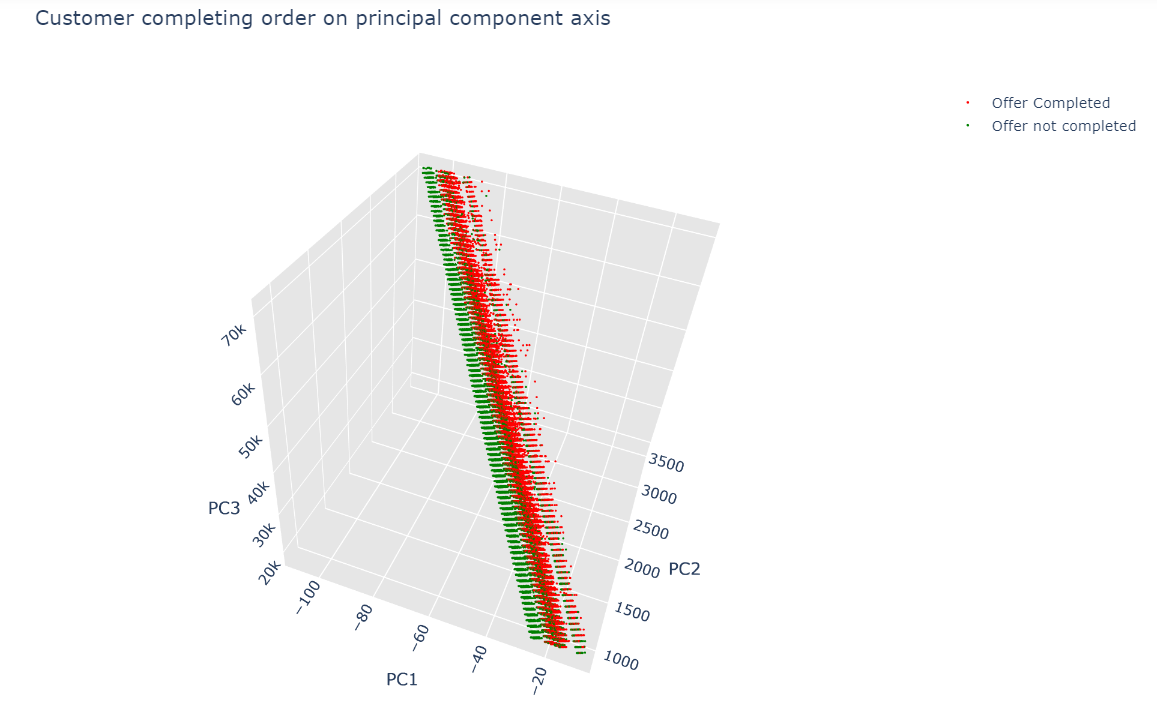

## Data Modelling

We will begin by fitting the Logistic Regression model to our dataset which we will use as benchmark. We will use accuracy due to:
1. Dataset being balanced
2. There is no severe consequence for False positive (Sending offer to a customer that won't complete it) or false negative        (not sending an offer to a customer that would have completed). Though we will keep an eye on both metrics in the evaluation    phase.


In [308]:
#Splitting data into train/test set
#Algorithms will be evaluated using CV on train set which will create our dev set

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.15 ,stratify=Y)

In [317]:
XGB=XGBClassifier()
RF=RandomForestClassifier()
LR=LogisticRegression(max_iter=1000)

In [321]:

results=[]
names=[]
num_folds=5
seed=5
kfold = StratifiedKFold(n_splits=num_folds)
cv_results = cross_val_score(LR, X_train, y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
names.append('LR')
msg = "%s: %f (%f)" % ('LR Accuracy', cv_results.mean(), cv_results.std())
print(msg)

C:\Users\diegbuca\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



LR Accuracy: 0.714627 (0.033987)


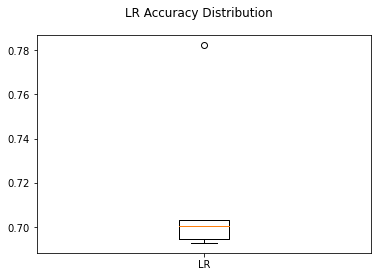

In [324]:

fig = pyplot.figure()
fig.suptitle('LR Accuracy Distribution')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [329]:
LR.fit(X_train,y_train)
predictions=LR.predict(X_train)

In [330]:
print('Prediction for LR')
print(accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))
#78.6% is the benchmark we have to achieve with the other models on the training set

Prediction for LR
0.7863959780154233
[[17739  5452]
 [ 4575 19176]]
              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78     23191
         1.0       0.78      0.81      0.79     23751

    accuracy                           0.79     46942
   macro avg       0.79      0.79      0.79     46942
weighted avg       0.79      0.79      0.79     46942



In [335]:
results=[]
names=[]
msgs=[]
num_folds=5
seed=5
models=[(LR,'LR'),(RF,'RF'),(XGB,'XGB')]
for model,name in models:
    kfold = StratifiedKFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    msgs.append(msg)
    print(msg)

LR: 0.714627 (0.033987)
RF: 0.850028 (0.003762)
XGB: 0.854544 (0.002497)


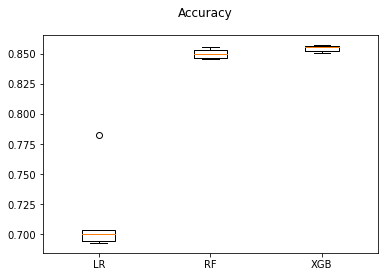

In [338]:
fig = pyplot.figure()
fig.suptitle('Accuracy')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()
#RF and XGB are superior on the training set looking at cross validation numbers.

In [342]:
RF.fit(X_train,y_train)
predictions=RF.predict(X_train)
print('Prediction for RF')
print(accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))
#Overfitting the training set? Let's see how it generalises to test set.

Prediction for RF
0.9999786971155894
[[23191     0]
 [    1 23750]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     23191
         1.0       1.00      1.00      1.00     23751

    accuracy                           1.00     46942
   macro avg       1.00      1.00      1.00     46942
weighted avg       1.00      1.00      1.00     46942



In [341]:
XGB.fit(X_train,y_train)
predictions=XGB.predict(X_train)
print('Prediction for XGB')
print(accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))

Prediction for XGB
0.8823228665161262
[[19560  3631]
 [ 1893 21858]]
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.88     23191
         1.0       0.86      0.92      0.89     23751

    accuracy                           0.88     46942
   macro avg       0.88      0.88      0.88     46942
weighted avg       0.88      0.88      0.88     46942



In [344]:
accuracy_trainingset={'LR':0.78639,'RF':0.99997,'XGB':0.882322}

In [380]:
pd.DataFrame([accuracy_trainingset],index=['out of the box on training set'])

LR       RF       XGB
out of the box on training set  0.78639  0.99997  0.882322

Both Random Forest and XGBoost are outperforming our benchmark model. However we can see some signs of overfitting in the case of Random Forest classifier. This will only be confirmed after looking at how it performs on the test set. Will it keep the same accuracy? 
Let's keep that in mind in the final evaluation.

### Hyperparameter tuning

In this section we are going to tune the hyperparameters of RF and XGBoost and pick the best parameters.
These will be computed using RandomSearch to save computational power and time due to the high combinations of hyperparameters that both Random Forest and XGBoost may have. 
Furthermore, we will employ Cross Validation, meaning that the performance will be based on a subsample of data that the the algorithm has not seen in the training phase. This will help us identify the hyperparameters which will generalise better to unseen data, our test set. At the end of this section we should see a better generalization of our algorithms on the test set vs the not tuned or out of the box version with default parameters.

In [349]:
#We are going to fine tune the following parameters for Random Forest:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 8)]
max_depth = [int(x) for x in np.linspace(10, 90, num = 9)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [352]:
clf = RandomizedSearchCV(RF,
                         param_distributions=grid,
                         scoring='accuracy',
                        n_iter = 50, cv = 3,n_jobs = -1)
search = clf.fit(X_train,y_train)


In [353]:
#Printing out best parameters for RF
print(search.best_params_)

{'n_estimators': 771, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}


In [354]:
#XGB params
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [355]:
clf = RandomizedSearchCV(XGB,
                         param_distributions=params,
                         scoring='accuracy',
                        n_iter = 50, cv = 3,n_jobs = -1)
search = clf.fit(X_train,y_train)

In [356]:
#Printing out best parameters for XGBoost
print(search.best_params_)

{'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 5, 'colsample_bytree': 1.0}


In [362]:
XGB_tuned=XGBClassifier(subsample=0.8,min_child_weight=1,max_depth=3,gamma=5,colsample_bytree=1)
RF_tuned=RandomForestClassifier(n_estimators=771,min_samples_split=5,min_samples_leaf=1,max_depth=10)


In [365]:
XGB_tuned.fit(X_train,y_train)
predictions=XGB_tuned.predict(X_train)
print('Prediction for XGB')
print(accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))

Prediction for XGB
0.8611477994120403
[[18989  4202]
 [ 2316 21435]]
              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     23191
         1.0       0.84      0.90      0.87     23751

    accuracy                           0.86     46942
   macro avg       0.86      0.86      0.86     46942
weighted avg       0.86      0.86      0.86     46942



In [366]:
RF_tuned.fit(X_train,y_train)
predictions=RF_tuned.predict(X_train)
print('Prediction for RF')
print(accuracy_score(y_train, predictions))
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, predictions))

Prediction for RF
0.8688168377998381
[[19035  4156]
 [ 2002 21749]]
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86     23191
         1.0       0.84      0.92      0.88     23751

    accuracy                           0.87     46942
   macro avg       0.87      0.87      0.87     46942
weighted avg       0.87      0.87      0.87     46942



In [367]:
accuracy_trainingset_tuned={'LR':np.nan,'RF':0.868816,'XGB':0.86114}

In [369]:
pd.DataFrame([accuracy_trainingset,accuracy_trainingset_tuned],index=['out of the box on training set','tuned on training set'])

LR        RF       XGB
out of the box on training set  0.78639  0.999970  0.882322
tuned on training set               NaN  0.868816  0.861140

On this first iteration one of the main findings is that both Random Forest and XGBoost are better performing than Logistic Regression on the training set. While at first glance it would appear that tuning the classifiers on the training set might have worsened performance, there are 2 reasons why this might have happened. 
1) Performance on training set has worsened but algorithms will generalise better when we test them on the test set. We will test this on the next section
2) We have used Random search and searched only a number of combinations out of many more available out there. We could continue searching for better parameters in case generalization on test set is not better.

## Test Set Evaluation

In [370]:
predictions=LR.predict(X_test)
print('Prediction for LR')
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Prediction for LR
0.7855159927579963
[[3113  980]
 [ 797 3395]]
              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      4093
         1.0       0.78      0.81      0.79      4192

    accuracy                           0.79      8285
   macro avg       0.79      0.79      0.79      8285
weighted avg       0.79      0.79      0.79      8285



In [371]:
predictions=RF.predict(X_test)
print('Prediction for RF')
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Prediction for RF
0.8500905250452625
[[3317  776]
 [ 466 3726]]
              precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      4093
         1.0       0.83      0.89      0.86      4192

    accuracy                           0.85      8285
   macro avg       0.85      0.85      0.85      8285
weighted avg       0.85      0.85      0.85      8285



In [372]:
predictions=XGB.predict(X_test)
print('Prediction for XGB')
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Prediction for XGB
0.8555220277610138
[[3322  771]
 [ 426 3766]]
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      4093
         1.0       0.83      0.90      0.86      4192

    accuracy                           0.86      8285
   macro avg       0.86      0.86      0.86      8285
weighted avg       0.86      0.86      0.86      8285



In [373]:
predictions=RF_tuned.predict(X_test)
print('Prediction for RF tuned')
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Prediction for RF tuned
0.8575739287869644
[[3296  797]
 [ 383 3809]]
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      4093
         1.0       0.83      0.91      0.87      4192

    accuracy                           0.86      8285
   macro avg       0.86      0.86      0.86      8285
weighted avg       0.86      0.86      0.86      8285



In [374]:
predictions=XGB_tuned.predict(X_test)
print('Prediction for XGB tuned')
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Prediction for XGB tuned
0.8555220277610138
[[3304  789]
 [ 408 3784]]
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85      4093
         1.0       0.83      0.90      0.86      4192

    accuracy                           0.86      8285
   macro avg       0.86      0.85      0.86      8285
weighted avg       0.86      0.86      0.86      8285



In [377]:
accuracy_test_set={'LR':0.785515,'RF':0.850090,'XGB':0.855522}
accuracy_test_set_tuned={'LR':np.nan,'RF':0.857573,'XGB':0.855522}

In [378]:
pd.DataFrame([accuracy_trainingset,
              accuracy_trainingset_tuned,
              accuracy_test_set,
              accuracy_test_set_tuned],index=['out of the box on training set',
                                              'tuned on training set',
                                             'out of the box on test set',
                                             'tuned on test set'])

LR        RF       XGB
out of the box on training set  0.786390  0.999970  0.882322
tuned on training set                NaN  0.868816  0.861140
out of the box on test set      0.785515  0.850090  0.855522
tuned on test set                    NaN  0.857573  0.855522

## Conclusions

For this project I conducted a full Machine Learning workflow from data cleaning/pre processing, feature engineering and model training.
I have then analysed a number of Supervised Learning Algorithm and fine tuned the hyperparameters.
The final results are summarized in this table:

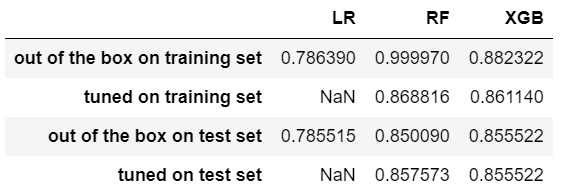

The best Model to deploy based on the above analysis is Random Forest with hyperparameters tuned as it provided a better generalization on the test set.
The model beats the benchmark that is Logistic Regression and it improves on the accuracy of the current model employed by Starbucks.

## Further Steps

There are further steps that can be employed, the following is a non exaustive list of suggestions:

1) check other classification algorithms

2) fine tune the models again by searching for longer to find better hyper parameters

3) perform further feature engineering to create more features that might help the algorithm increase accuracy

4) perform error analysis by looking at false positives or false negatives to understand why they were wrongly classified

5) try more complex models such as neaural networks